# Time series models

* Updated: 2022-10-02

In [1]:
%%capture
try:
  installed
except:
  installed = False
if not installed:
  !pip install yfinance
  installed = True

In [2]:
from typing import Dict, List

import calendar
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf

# Preliminary

In [5]:
orig = yf.download("BTC-USD",
   start="2013-10-01",
   end="2022-09-30",
   progress=False)
orig = orig[["Close", "Volume"]]
orig.reset_index(inplace=True)
orig.columns = orig.columns.str.lower()

In [6]:
data = orig.copy()
data["day_of_week"] = orig["date"].dt.day_of_week
data["day_of_year"] = orig["date"].dt.day_of_year
data["year"] = orig["date"].dt.year
data["month"] = orig["date"].dt.month

In [7]:
data.tail()

,date,close,volume,day_of_week,day_of_year,year,month
2931,2022-09-26,19222.671875,44148798321,0,269,2022,9
2932,2022-09-27,19110.546875,58571439619,1,270,2022,9
2933,2022-09-28,19426.720703,53071298734,2,271,2022,9
2934,2022-09-29,19573.050781,41037843771,3,272,2022,9
2935,2022-09-30,19431.789062,43975248085,4,273,2022,9


## EWMA

Exponentially weighted moving average.

In [8]:
def calc_ewma(y, w=0.9) -> np.ndarray:
  out = []
  out.append(y[0])
  for i in range(1, len(y)):
    out.append(w * y[i] + (1 - w) * out[i - 1])
  return np.array(out)

## Plotting

In [9]:
def plot_time_series(x, y, lab=None, last=None) -> None:
  if last:
    x_trunc = x[-last:]
    y_trunc = y[-last:]
  else:
    x_trunc = x
    y_trunc = y
  plt.plot(x_trunc, y_trunc, label=lab)
  plt.xlabel("Date")
  plt.ylabel("Close")
  if lab:
    plt.legend()
  plt.grid(True)
  return None

### Time series

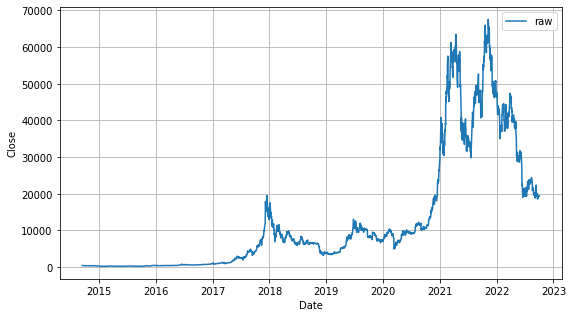

In [10]:
plt.figure(figsize=(9, 5))
plot_time_series(x=data.date, y=data.close, lab="raw")
plt.show()

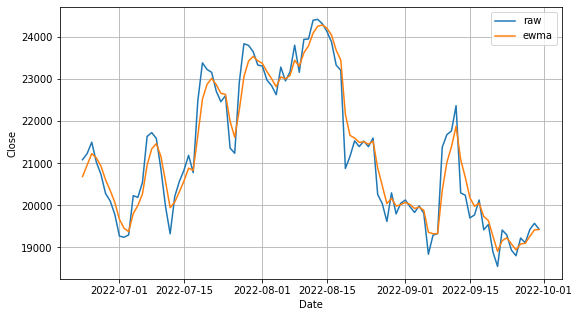

In [11]:
plt.figure(figsize=(9, 5))
data["ewma"] = calc_ewma(data.close, w=0.5)
plot_time_series(x=data.date, y=data.close, lab="raw", last=100)
plot_time_series(x=data.date, y=data.ewma, lab="ewma", last=100)
plt.show()

### Day of year

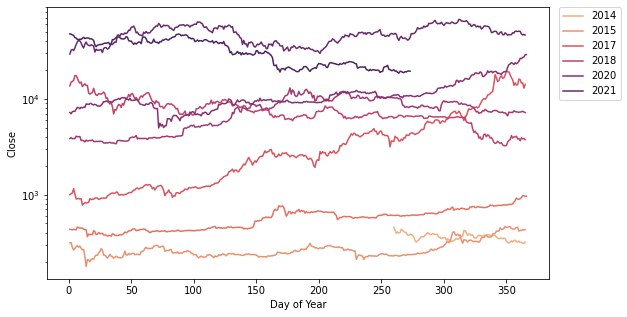

In [12]:
plt.figure(figsize=(9, 5))
sns.lineplot(
    x=data.day_of_year,
    y=data.close,
    hue=data.year,
    palette="flare"
)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Day of Year")
plt.ylabel("Close")
plt.yscale("log")
plt.show()

### Day of week

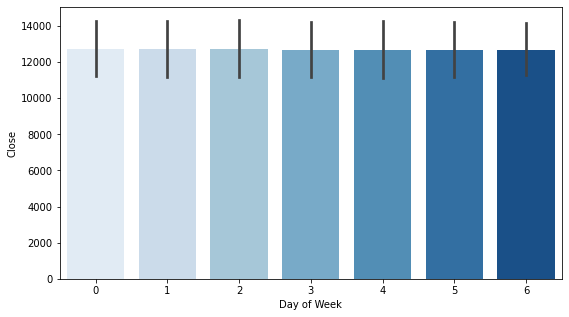

In [13]:
plt.figure(figsize=(9, 5))
sns.barplot(
    x="day_of_week",
    y="close",
    data=data,
    palette="Blues"
)
plt.xlabel("Day of Week")
plt.ylabel("Close")
plt.show()

### Month of year

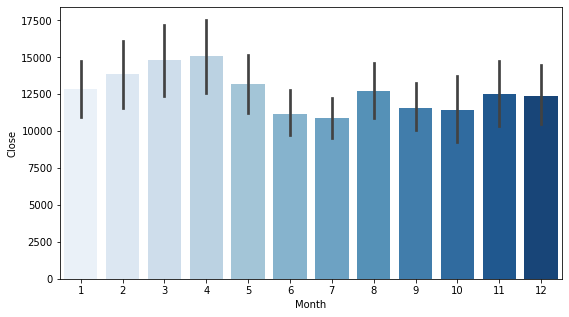

In [14]:
plt.figure(figsize=(9, 5))
sns.barplot(
    x="month",
    y="close",
    data=data,
    palette="Blues"
)
plt.xlabel("Month")
plt.ylabel("Close")
plt.show()

# Modeling

In [15]:
def rel_mae(y_true, y_pred) -> float:
  """Relative mean absolute error.

  Compares the mean absolute error to that of the model that simply predicts
  y[t+1] as y[t].
  
  """
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  mae = tf.reduce_mean(tf.abs(y_pred - y_true))
  ref = tf.reduce_mean(tf.abs(y_true[:-1] - y_true[1:]))
  ratio = tf.divide(mae, tf.math.maximum(ref, 0.001))
  return ratio

In [16]:
# Compare exponentially weighted moving average to 1-step ahead prediction.
y_true = data.close.to_numpy()[:-1]
y_pred_ewma = data.ewma.to_numpy()[1:]
rel_mae(y_true, y_pred_ewma)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6078379>

## Data preparation

* See [tf.keras.utils.timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array).

In [17]:
def split(
  data: pd.DataFrame,
  train_prop=0.8,
  val_prop=0.1,
) -> Dict[str, pd.DataFrame]:
  """Split data in training, validation, and testing sets."""
  test_prop = 1 - (train_prop + val_prop)
  assert test_prop >= 0
  n = len(data.index)

  n_train = int(train_prop * n)
  n_val = int(val_prop * n)
  n_test = int(test_prop * n)

  out = {}
  out["train"] = data.loc[:n_train]
  out["val"] = data.loc[n_train:(n_train + n_val)]
  out["test"] = data.loc[(n_train + n_val):]
  return out

In [18]:
def gen_windows(
  input: tf.Tensor,
  x_len=7
) -> tf.Tensor:
    return input[:, :x_len], input[:, x_len:]

In [19]:
def create_datasets(
  data: pd.DataFrame,
  x_len: int,
  y_len: int,
  batch_size=128,
  idx_name="date",
  train_prop=0.8,
  val_prop=0.1,
  y_name="close"
) -> Dict[str, Dict]:
  split_data = split(data, train_prop, val_prop)
  total_len = x_len + y_len
  datasets = {}
  indexsets = {}
  for key in split_data.keys():
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=split_data[key][y_name],
      targets=None,
      sequence_length=total_len,
      batch_size=batch_size,
    )
    ds = ds.map(lambda x: gen_windows(x, x_len))
    datasets[key] = ds.prefetch(tf.data.AUTOTUNE)


    ids = tf.keras.utils.timeseries_dataset_from_array(
      data=np.datetime_as_string(split_data[key][idx_name], unit="D"),
      targets=None,
      sequence_length=total_len,
      batch_size=batch_size,
    )
    indexsets[key] = ids.map(lambda x: gen_windows(x, x_len))
  return datasets, indexsets

## Training and evluation functions

In [20]:
def compile_model(
    model: tf.keras.models.Model,
    eager=False,
  ) -> tf.keras.models.Model:
  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[rel_mae],
    run_eagerly=eager
  )
  return model

In [21]:
def checkpoint_callback(exp_name: str, logdir="logs") -> tf.keras.callbacks.Callback:
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(logdir, exp_name),
    save_best_only=True,
    verbose=0,
  )

In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
  )

In [23]:
def plot_history(history: tf.keras.callbacks.History) -> None:
  """Plot training and validation relative MAE."""
  df = pd.DataFrame(history.history)
  plt.plot(df.rel_mae, label="Train")
  plt.plot(df.val_rel_mae, label="Val")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Relative MAE")
  plt.show()
  return None

In [24]:
def get_predictions(
    model: tf.keras.models.Model,
    test_ds: tf.data.Dataset,
    test_ids: tf.data.Dataset,
) -> np.ndarray:
  yhat = model.predict(x=test_ds)
  yhat = np.squeeze(np.array(yhat))
  
  idx = np.concatenate([y for x, y in test_ids])
  ytrue = np.concatenate([y for x, y in test_ds])

  if yhat.ndim == 1:
    out = {
      "idx": np.squeeze(idx.astype(str)),
      "ytrue": np.squeeze(ytrue),
      "yhat": yhat
    }
  else:

    # Reduce to 1 prediction per time point.
    unique_ids = np.unique(idx)
    out = {"idx": [], "ytrue": [], "yhat": []}
    for uid in unique_ids:
      out["idx"].append(uid.decode("utf-8"))
      out["ytrue"].append(np.mean(ytrue[idx == uid]))
      out["yhat"].append(np.mean(yhat[idx == uid]))

  out = pd.DataFrame(out)
  out["idx"] = pd.to_datetime(out["idx"])
  return out

In [25]:
def plot_predictions(
  pred_df: pd.DataFrame,
) -> None:
  """Plot observed vs. predicted time series."""
  plt.figure(figsize=(10, 5))
  plt.plot(pred_df.idx, pred_df.ytrue, label="Truth")
  plt.plot(pred_df.idx, pred_df.yhat, label="Prediction")
  plt.legend()
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.show()
  return None

## Dense: given 7, predict 1.

In [79]:
datasets, indexsets = create_datasets(data, x_len=7, y_len=1)

In [ ]:
inputs = tf.keras.layers.Input(shape=(7, ), name="input")
h = tf.keras.layers.Dense(128, activation="selu", name="dense1")(inputs)
output = tf.keras.layers.Dense(1, name="output")(h)
model = tf.keras.models.Model(inputs, output, name="dense_model")

In [ ]:
model = compile_model(model)

In [ ]:
history = model.fit(
  x=datasets["train"],
  batch_size=None,
  validation_data=datasets["val"],
  epochs=100,
  callbacks=[
    checkpoint_callback("dense_7_1"),
    early_stop,
  ],
  verbose=1
)

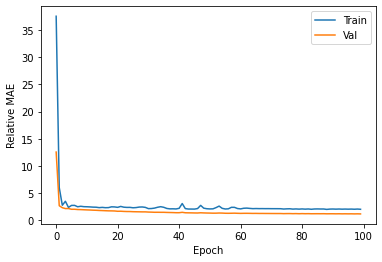

In [ ]:
plot_history(history)

In [ ]:
# Load model.
model = tf.keras.models.load_model(
  "logs/dense_7_1",
  custom_objects={"rel_mae": rel_mae}
)

In [ ]:
pred_df = get_predictions(model, datasets["test"], indexsets["test"])
pred_df.head()

,idx,ytrue,yhat
0,2021-12-04,49200.703125,55461.398438
1,2021-12-05,49368.847656,52159.214844
2,2021-12-06,50582.625000,50357.625000
3,2021-12-07,50700.085938,49863.769531
4,2021-12-08,50504.796875,49711.226562


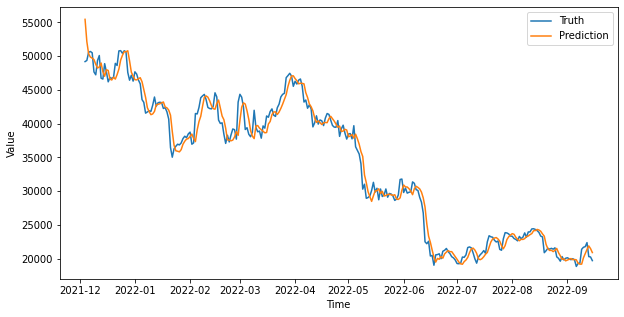

In [ ]:
plot_predictions(pred_df)

In [ ]:
model.evaluate(x=datasets["test"])

3/3 [==============================] - 0s 14ms/step - loss: 1074.6064 - rel_mae: 1.3274


[1074.6064453125, 1.327426552772522]

## Dense: given 7, predict 3.

In [80]:
datasets, indexsets = create_datasets(data, x_len=7, y_len=3)

In [81]:
inputs = tf.keras.layers.Input(shape=(7, ), name="input")
h = tf.keras.layers.Dense(128, activation="selu", name="dense1")(inputs)
output = tf.keras.layers.Dense(3, name="output")(h)
model = tf.keras.models.Model(inputs, output, name="dense_model")

In [82]:
model = compile_model(model)

In [83]:
history = model.fit(
  x=datasets["train"],
  batch_size=None,
  validation_data=datasets["val"],
  epochs=100,
  callbacks=[
    checkpoint_callback("dense_7_3"),
    early_stop,
  ],
  verbose=0
)

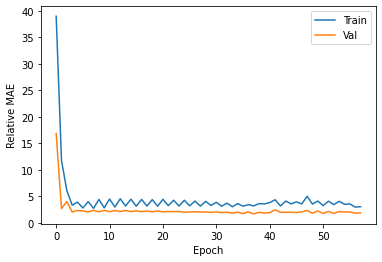

In [84]:
plot_history(history)

In [85]:
# Load model.
model = tf.keras.models.load_model(
  "logs/dense_7_3",
  custom_objects={"rel_mae": rel_mae}
)

In [86]:
pred_df = get_predictions(model, datasets["test"], indexsets["test"])
pred_df.head()

,idx,ytrue,yhat
0,2021-12-17,46202.144531,48079.089844
1,2021-12-18,46848.777344,48140.117188
2,2021-12-19,46707.015625,47579.402344
3,2021-12-20,46880.277344,47142.359375
4,2021-12-21,48936.613281,47425.777344


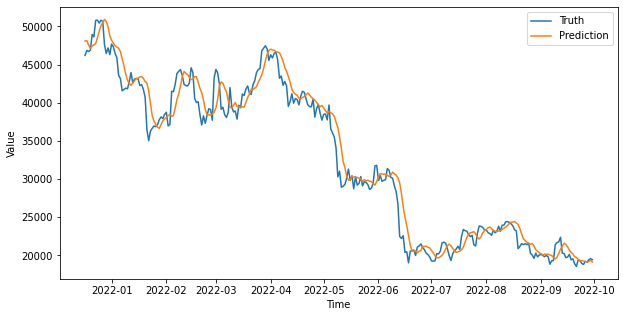

In [87]:
plot_predictions(pred_df)

In [88]:
model.evaluate(x=datasets["test"])

3/3 [==============================] - 0s 11ms/step - loss: 1427.1365 - rel_mae: 1.7765


[1427.136474609375, 1.7764514684677124]

## Convolutional

In [ ]:
datasets, indexsets = create_datasets(data, x_len=7, y_len=1)

In [ ]:
inputs = tf.keras.layers.Input(shape=(7, ), name="input")
h = tf.keras.layers.Lambda(
    lambda x: tf.expand_dims(x, axis=-1), name="expand_dims")(inputs)
h1 = tf.keras.layers.Conv1D(32, 3, activation="relu", padding="causal", name="conv3")(h)
h2 = tf.keras.layers.Conv1D(32, 5, activation="relu", padding="causal", name="conv5")(h)
h3 = tf.keras.layers.Conv1D(32, 7, activation="relu", padding="causal", name="conv7")(h)
h = tf.keras.layers.Concatenate(name="concat")([h1, h2, h3])
h = tf.keras.layers.Conv1D(4, 1, activation="relu", padding="same", name="conv1")(h)
h = tf.keras.layers.Flatten(name="flat")(h)
output = tf.keras.layers.Dense(1, name="output")(h)
model = tf.keras.models.Model(inputs, output, name="conv_model")

In [ ]:
model = compile_model(model)

In [ ]:
history = model.fit(
  x=datasets["train"],
  batch_size=None,
  validation_data=datasets["val"],
  epochs=100,
  callbacks=[
    checkpoint_callback("conv_1d"),
    early_stop,
  ],
  verbose=0
)

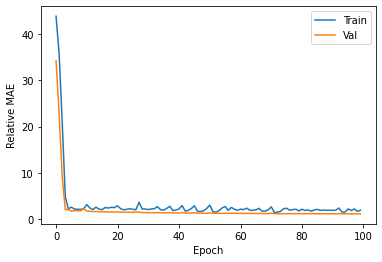

In [ ]:
plot_history(history)

In [ ]:
# Load model.
model = tf.keras.models.load_model(
  "logs/conv_1d",
  custom_objects={"rel_mae": rel_mae}
)

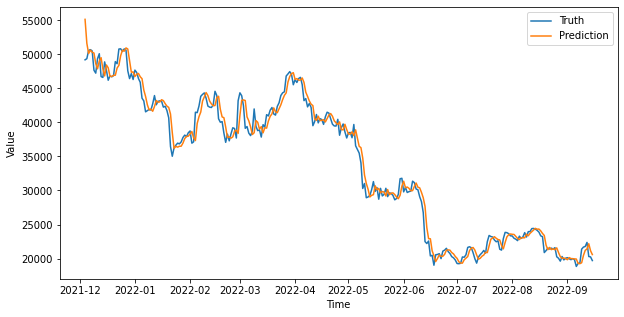

In [ ]:
pred_df = get_predictions(model, datasets["test"], indexsets["test"])
plot_predictions(pred_df)

In [ ]:
model.evaluate(x=datasets["test"])

3/3 [==============================] - 0s 11ms/step - loss: 993.1893 - rel_mae: 1.2205


[993.1892700195312, 1.220543622970581]

## LSTM

In [89]:
datasets, indexsets = create_datasets(data, x_len=7, y_len=1)

In [90]:
inputs = tf.keras.layers.Input(shape=(7, ), name="input")
h = tf.keras.layers.Lambda(
    lambda x: tf.expand_dims(x, axis=-1), name="expand_dims")(inputs)
h = tf.keras.layers.LSTM(64, activation="relu", name="lstm")(h)
outputs = tf.keras.layers.Dense(1, name="output")(h)
model = tf.keras.Model(inputs, outputs, name="lstm_model")

In [91]:
model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 7)]               0         
                                                                 
 expand_dims (Lambda)        (None, 7, 1)              0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [92]:
model = compile_model(model)

In [ ]:
history = model.fit(
  x=datasets["train"],
  batch_size=None,
  validation_data=datasets["val"],
  epochs=100,
  callbacks=[
    checkpoint_callback("lstm"),
    early_stop,
  ],
  verbose=0
)

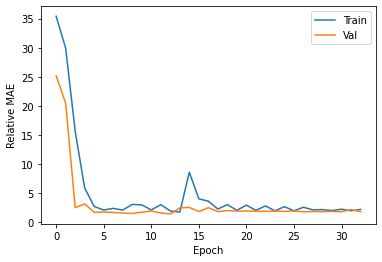

In [94]:
plot_history(history)

In [ ]:
# Load model.
model = tf.keras.models.load_model(
  "logs/lstm",
  custom_objects={"rel_mae": rel_mae}
)

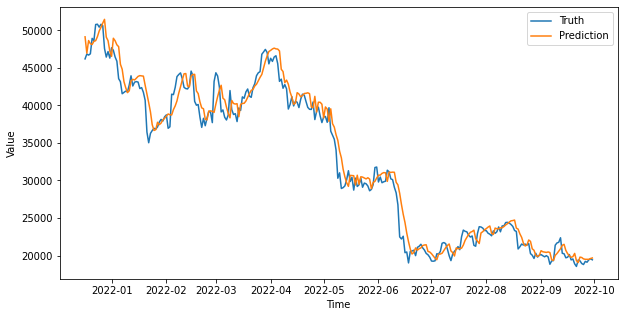

In [96]:
pred_df = get_predictions(model, datasets["test"], indexsets["test"])
plot_predictions(pred_df)

In [97]:
model.evaluate(x=datasets["test"])

3/3 [==============================] - 0s 11ms/step - loss: 1217.1228 - rel_mae: 1.5429


[1217.122802734375, 1.542908787727356]

## Multivariate

### Prepare data

In [98]:
WINDOW_SIZE = 7

In [99]:
eth = yf.download("ETH-USD",
   start="2013-10-01",
   end="2022-09-30",
   progress=False)
eth = eth[["Close"]]
eth.reset_index(inplace=True)
eth.columns = ["date", "eth"]

In [100]:
btc_eth = data.merge(eth, on="date")
btc_eth.rename(columns={"close": "btc"}, inplace=True)

In [101]:
btc_eth.index = btc_eth.date
btc_eth = btc_eth[["btc", "eth"]]

In [102]:
for i in range(WINDOW_SIZE):
  btc_eth[f"btc+{i+1}"] = btc_eth.btc.shift(periods = i + 1)
  btc_eth[f"eth+{i+1}"] = btc_eth.eth.shift(periods = i + 1)

In [103]:
btc_eth.dropna(inplace=True)
x_btc = np.array(btc_eth[[f"btc+{i+1}" for i in range(WINDOW_SIZE)]], dtype=np.float32)
x_eth = np.array(btc_eth[[f"eth+{i+1}" for i in range(WINDOW_SIZE)]], dtype=np.float32)

y_btc = np.array(btc_eth["btc"], dtype=np.float32)
y_eth = np.array(btc_eth["eth"], dtype=np.float32)

assert x_btc.shape == x_eth.shape
assert y_btc.shape == y_eth.shape

In [104]:
n = len(btc_eth.index)
n_train = int(n * 0.8)

btc_eth_data = {
   "x_train": np.hstack([x_btc[:n_train, :], x_eth[:n_train, :]]),
   "y_train": np.vstack([y_btc[:n_train], y_eth[:n_train]]).transpose(),
   "x_val": np.hstack([x_btc[n_train:n, :], x_eth[n_train:n, :]]),
   "y_val": np.vstack([y_btc[n_train:n], y_eth[n_train:n]]).transpose(),
}

In [105]:
assert btc_eth_data["x_train"].shape[0] == btc_eth_data["y_train"].shape[0]
assert btc_eth_data["x_val"].shape[0] == btc_eth_data["y_val"].shape[0]

### Training

In [106]:
inputs = tf.keras.layers.Input(shape=(14, ), name="input")
h = tf.keras.layers.Dense(32, activation="selu", name="dense1")(inputs)
h = tf.keras.layers.Dense(16, activation="selu", name="dense2")(h)
h = tf.keras.layers.Dense(8, activation="selu", name="dense3")(h)
output = tf.keras.layers.Dense(2, name="output")(h)
model = tf.keras.models.Model(inputs, output, name="dense_model")

In [107]:
model = compile_model(model)

In [ ]:
history = model.fit(
  x=btc_eth_data["x_train"],
  y=btc_eth_data["y_train"],
  batch_size=32,
  validation_data=(
    btc_eth_data["x_val"], 
    btc_eth_data["y_val"], 
  ),
  epochs=100,
  callbacks=[
    checkpoint_callback("biviarate"),
    early_stop,
  ],
  verbose=0
)

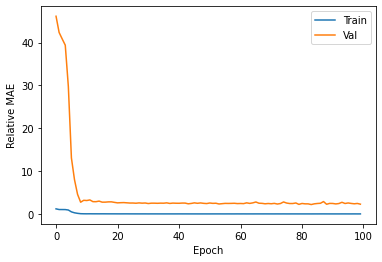

In [109]:
plot_history(history)

### Predict

In [110]:
y_val = btc_eth_data["y_val"]
y_hat = model.predict(btc_eth_data["x_val"])

In [111]:
preds = pd.DataFrame({
  "idx": btc_eth.iloc[n_train:n].index,
  "btc_true": y_val[:, 0],
  "eth_true": y_val[:, 1],
  "btc_hat": y_hat[:, 0],
  "eth_hat": y_hat[:, 1],
})

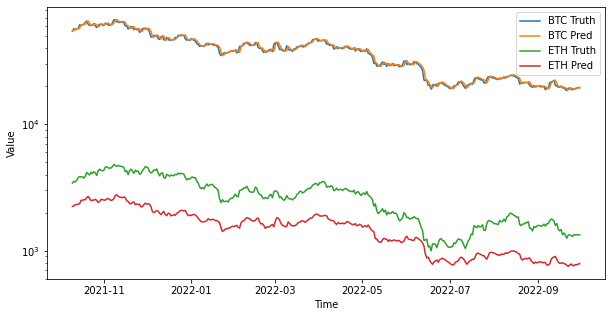

In [112]:
# Plot both series. 
plt.figure(figsize=(10, 5))
plt.plot(preds.idx, preds.btc_true, label="BTC Truth")
plt.plot(preds.idx, preds.btc_hat, label="BTC Pred")
plt.plot(preds.idx, preds.eth_true, label="ETH Truth")
plt.plot(preds.idx, preds.eth_hat, label="ETH Pred")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.yscale("log")
plt.show()

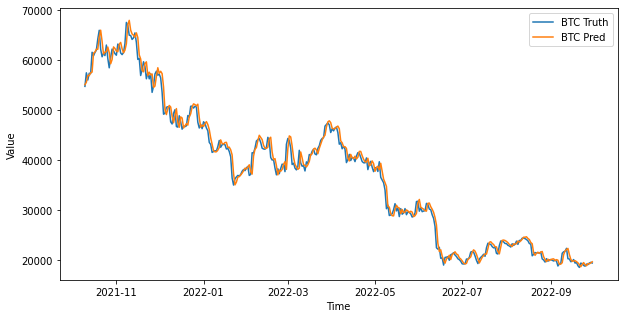

In [114]:
# Plot BTC specifically.
plt.figure(figsize=(10, 5))
plt.plot(preds.idx, preds.btc_true, label="BTC Truth")
plt.plot(preds.idx, preds.btc_hat, label="BTC Pred")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [115]:
# BTC relative MAE.
rel_mae(preds.btc_true, preds.btc_hat).numpy()

1.0848371

## N-Beats

In [27]:
class Block(tf.keras.layers.Layer):

  def __init__(
    self,
    n_neurons: int,
    horizon=1,
    n_layers=4,
    theta_size=12,
    window_size=7,
    **kwargs
  ):
    super().__init__(**kwargs)
    self.horizon = horizon
    self.window_size = window_size
    self.n_layers = n_layers
    self.n_neurons = n_neurons
    self.theta_size = theta_size
  
    self.hidden = [
        tf.keras.layers.Dense(n_neurons, activation="relu", name=f"d{i}") for \
        i in range(n_layers)
    ]
    self.theta_layer = tf.keras.layers.Dense(theta_size, name="theta")
    self.backcast_layer = tf.keras.layers.Dense(window_size, name="backcast")
    self.forecast_layer = tf.keras.layers.Dense(horizon, name="forecast")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast = self.backcast_layer(theta)
    forecast = self.forecast_layer(theta)
    return backcast, forecast

In [28]:
test_block = Block(n_neurons=8)

In [29]:
tf.random.set_seed(101)
test_inputs = tf.random.poisson(shape=(4, 8), lam=4)

In [30]:
test_inputs

<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[ 5.,  9.,  4.,  3.,  1.,  6.,  9.,  5.],
       [ 4.,  1.,  2.,  3.,  3.,  5.,  5.,  6.],
       [ 1.,  3.,  3.,  4.,  5., 11.,  2.,  4.],
       [ 3.,  7.,  2.,  6.,  3.,  2.,  4.,  2.]], dtype=float32)>

In [31]:
test_block(test_inputs)

(<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
 array([[ 1.0708659 ,  1.0491823 ,  0.14034718,  1.403913  , -3.5246496 ,
          0.5375268 ,  3.1067255 ],
        [ 0.5370686 ,  0.69072276, -0.0974423 ,  0.82638925, -2.272731  ,
          0.56646377,  2.2223327 ],
        [ 0.7046989 ,  0.95274943, -0.12280437,  1.1332752 , -3.130341  ,
          0.7642467 ,  3.0319664 ],
        [ 0.78727037,  0.96976954,  0.5744223 ,  1.4363956 , -2.8318136 ,
          0.21567658,  2.384509  ]], dtype=float32)>,
 <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[-0.88896763],
        [-0.8707376 ],
        [-1.1535821 ],
        [-0.10468924]], dtype=float32)>)

In [32]:
class NBeats(tf.keras.models.Model):

  def __init__(
    self,
    horizon=1,
    n_blocks=10,
    n_neurons=128,
    window_size=7,
    **kwargs
  ):
    super().__init__(**kwargs)
    self.blocks = {
      f"b{i}": Block(
        n_neurons=n_neurons,
        horizon=horizon,
        window_size=window_size,
        name=f"block{i}"
      ) for i in range(n_blocks)
    }
    self.n_blocks = n_blocks
    self.linear = tf.keras.layers.Dense(horizon, name="linear")


  def call(self, inputs):
    x = inputs
    b0 = self.blocks["b0"]
    forecasts = []

    # Generate back/fore-casts from first block.
    residuals, y = b0(x)
    forecasts.append(y)

    # Loop over remaining blocks.
    for i in range(1, self.n_blocks):
      block = self.blocks[f"b{i}"]
      backcast, y = block(residuals)
      forecasts.append(y)

      # Subtract backcast from current residuals.
      residuals = tf.keras.layers.subtract([residuals, backcast])
    
    # Combine forecasts.
    forecasts = tf.keras.layers.concatenate(forecasts)
    final = self.linear(forecasts)
    return final

In [33]:
test_model = NBeats()

In [34]:
test_model(test_inputs)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[-0.21053952],
       [-0.08180936],
       [-0.10581684],
       [-0.04016558]], dtype=float32)>

### Training

In [168]:
datasets, indexsets = create_datasets(data, x_len=7, y_len=1)

In [169]:
n_blocks = 10
model = NBeats(n_blocks=n_blocks)
# Build is necessary to specify the input shape.
model.build((None, 7))

In [170]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=tf.keras.losses.MeanAbsoluteError(),
  metrics=[rel_mae],
)

In [ ]:
history = model.fit(
  x=datasets["train"],
  validation_data=datasets["val"],
  epochs=100,
  callbacks=[
    checkpoint_callback(f"nbeats_{n_blocks}"),
    early_stop,
  ],
  verbose=0
)

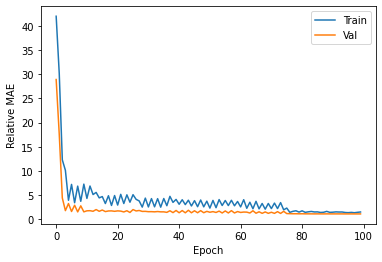

In [36]:
plot_history(history)

### Evaluation

In [38]:
# Load model.
model = tf.keras.models.load_model(
  "logs/nbeats_5",
  custom_objects={"rel_mae": rel_mae}
)

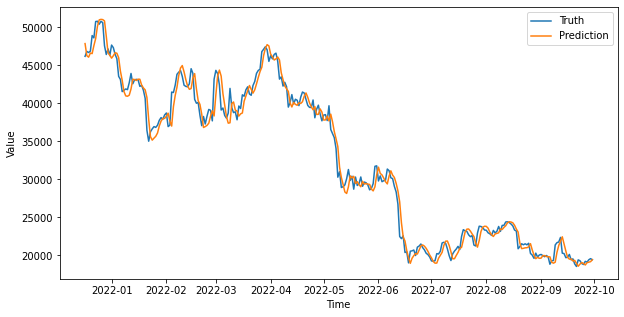

In [39]:
pred_df = get_predictions(model, datasets["test"], indexsets["test"])
plot_predictions(pred_df)

In [40]:
model.evaluate(x=datasets["test"])

3/3 [==============================] - 0s 15ms/step - loss: 946.1511 - rel_mae: 1.2079


[946.151123046875, 1.207873821258545]

### Ensembling

#### Training

In [ ]:
n_blocks = [2, 5, 8, 10]
for b in n_blocks:
  
  # Specify model.
  model = NBeats(n_blocks=b)
  model.build((None, 7))
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[rel_mae],
  )

  # Fit model.
  model.fit(
    x=datasets["train"],
    validation_data=datasets["val"],
    epochs=100,
    callbacks=[
      checkpoint_callback(f"nbeats_{b}"),
      early_stop,
    ],
    verbose=1
  )

#### Prediction

In [ ]:
predictions = []
for b in n_blocks:

  # Load model.
  model = tf.keras.models.load_model(
    f"logs/nbeats_{b}",
    custom_objects={"rel_mae": rel_mae}
  )

  # Generate predictions.
  yhat = model.predict(x=datasets["test"])
  predictions.append(yhat)

In [117]:
yhat_ensembl = np.concatenate(predictions, axis=1)
yhat_ensembl = np.mean(yhat_ensembl, axis=1)

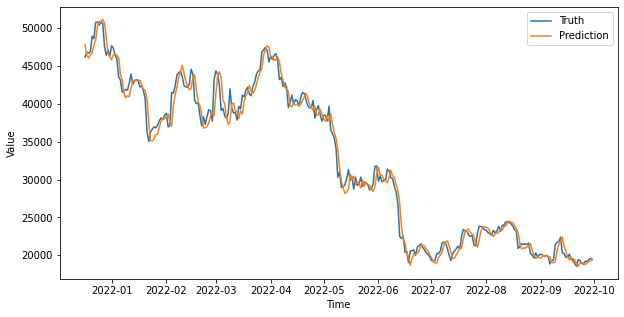

In [118]:
pred_df = get_predictions(model, datasets["test"], indexsets["test"])
pred_df["yhat"] = yhat_ensembl
plot_predictions(pred_df)

In [119]:
rel_mae(pred_df.ytrue, pred_df.yhat).numpy()

1.1849325

### Forecast

In [167]:
def gen_forecast(
  init_data: np.ndarray,
  model: tf.keras.models.Model,
  steps: int,
  window_size=7,
) -> np.ndarray:
  """Generate forecast.
  
  Note: this function uses the same model to make each prediction. An
  improved approach might fine-tune the model using the "new" data generated
  at each time step.

  """
  init_data = init_data[-window_size:]
  init_data = np.expand_dims(init_data, axis=0)

  x = init_data
  preds = []
  for i in range(steps):
    yhat = model.predict(x)
    preds.append(np.squeeze(yhat))

    x = np.concatenate([x, yhat], axis=1)
    x = x[:, -window_size:]
  
  return np.array(preds)

In [165]:
def plot_forecast(
  init_dates: np.ndarray,
  init_values: np.ndarray,
  forecast: np.ndarray,
  length_history=14,
) -> None:
  """Plot forecast.
  
  Assumes the unit of time is days.

  """
  init_dates = np.array(init_dates[-length_history:], dtype="datetime64[D]")
  init_values = np.array(init_values[-length_history:], dtype=np.float32)
  n_steps = len(projection)
  
  t0 = init_dates[-1]
  future_dates = [t0 + i for i in range(n_steps + 1)]

  augmented_forecast = np.insert(forecast, 0, init_values[-1])

  # Plotting.
  plt.figure(figsize=(10, 5))
  plt.plot(init_dates, init_values, label="History")
  plt.plot(future_dates, augmented_forecast, label="Forecast")
  plt.legend()
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.show()
  return None

In [130]:
model = tf.keras.models.load_model(
    f"logs/nbeats_10",
    custom_objects={"rel_mae": rel_mae}
  )

In [131]:
forecast = gen_forecast(
  init_data=np.array(data.close),
  model=model,
  steps=14
)

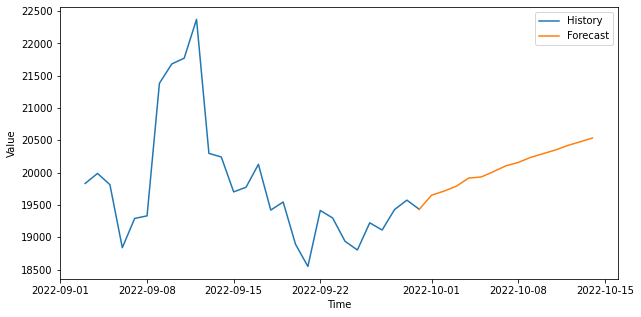

In [166]:
# Plotting.
plot_forecast(
  data.date,
  data.close,
  forecast,
  length_history=28
)